In [ ]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
from utils.loss import calculate_RMS
import matplotlib.pyplot as plt

# Initialize: config for TML
WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.
wl = 750. # wl used for calculating OT

def plot_film(f: FilmSimple):
    f.add_spec_param(INC_ANG, WLS)
    spec_target = f.get_spec()
    spec_target.calculate() # compile cuda kernel func
    plot_spectrum(spec_target)

np.random.seed(1)
f_target = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(30) * 100) # target film for TML
plot_film(f_target)

Should be 1 dim array! (run 0)


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='init ot / nm', ylabel='loss (RMS)'>)

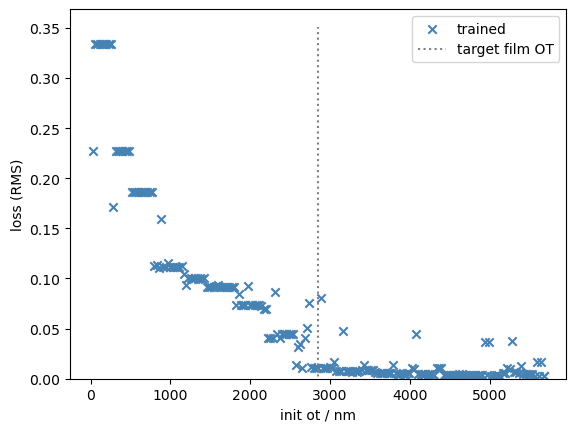

In [23]:
# Load trained films data and construct Design objects

designs = []

for run_idx in range(200):
    try:
        design = DesignSimple(f_target,
                            FilmSimple('SiO2', 
                                        'TiO2',
                                        'SiO2',
                                        np.loadtxt(f'./../raw_design_result/50iters_0to2OT_200run/run_{run_idx}/final')*1000.
                                        ),
                            init_ot=run_idx / 200 * 2 * f_target.get_optical_thickness(wl) # init ot is ratio * target ot, run 199 is 2 target ot
                            )
        design.film.add_spec_param(inc_ang=INC_ANG, wls=WLS)
        design.film.calculate_spectrum()
        design.calculate_loss()

        designs.append(design)
    except Exception as e:
        print(e, f"(run {run_idx})")
        continue # skip invalid d


def plot(design_list):
    fig, ax = plt.subplots(1, 1)
    for design in design_list:
        ax.scatter(design.init_ot, design.loss, c='steelblue', marker='x')

    # scatter the first dot for the legend
    ax.scatter(design.init_ot, design.loss, c='steelblue', marker='x', label='trained')

    target_ot = design.target_film.get_optical_thickness(wl)
    ax.plot([target_ot, target_ot], ax.get_ylim(), label='target film OT', c='gray', ls=':')
    
    ax.legend()
    ax.set_xlabel('init ot / nm')
    ax.set_ylabel('loss (RMS)')
    ax.set_ylim(0, None) # set lower bound of y to zero
    return fig, ax

plot(designs)
        

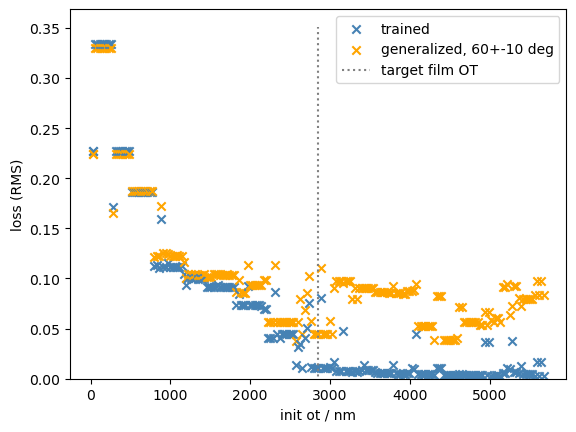

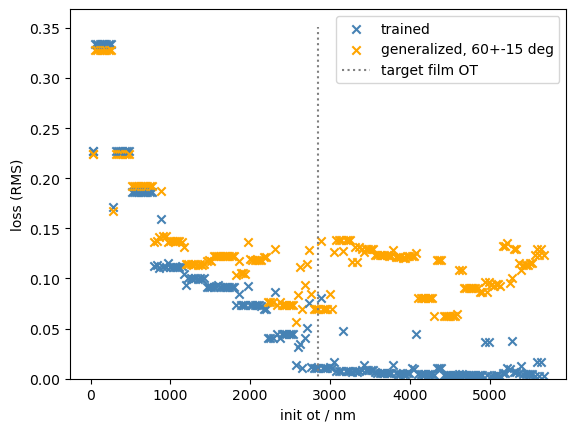

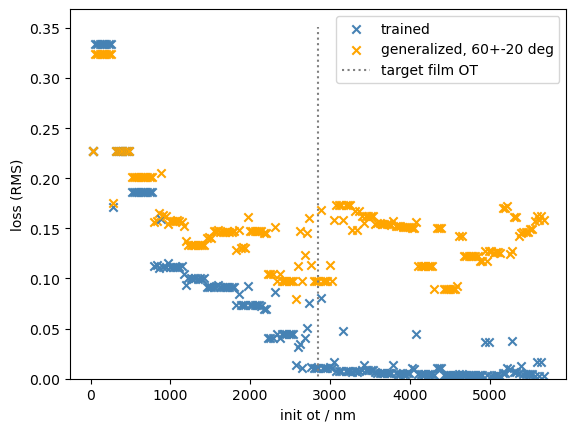

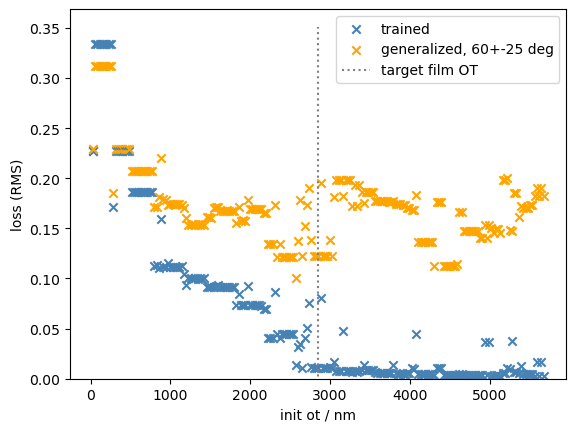

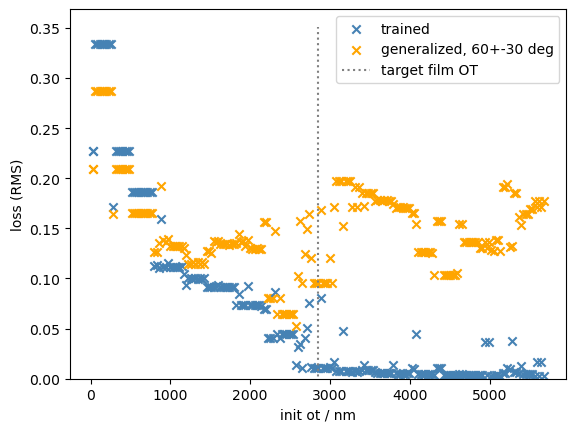

In [19]:
gen_angs_biases = list(range(10, 35, 5))

gen_number = len(gen_angs_biases)

for i, gen_angs_bias in zip(range(gen_number), gen_angs_biases):
    gen_angs = [60. - gen_angs_bias, 60. + gen_angs_bias]

    def generalize(designs):
        gen_designs = []
        for design in designs:
            gen_design = copy.deepcopy(design)
            for inc_ang in gen_angs:
                gen_design.target_film.add_spec_param(inc_ang, WLS)
                gen_design.film.add_spec_param(inc_ang, WLS)
            gen_design.calculate_loss()
            gen_designs.append(gen_design)
        return gen_designs

    gen_designs = generalize(designs)

    def plot(design_list, gen_designs_list):
        fig, ax = plt.subplots(1, 1)
        for design, gen_design in zip(design_list, gen_designs_list):
            ax.scatter(design.init_ot, design.loss, c='steelblue', marker='x')
            ax.scatter(gen_design.init_ot, gen_design.loss, c='orange', marker='x')

        # scatter the first dot for the legend
        design, gen_design = designs[0], gen_designs[0]
        ax.scatter(design.init_ot, design.loss, c='steelblue', marker='x', label='trained')
        ax.scatter(gen_design.init_ot, gen_design.loss, c='orange', marker='x', label=f'generalized, 60+-{gen_angs_bias} deg')

        target_ot = design.target_film.get_optical_thickness(wl)
        ax.plot([target_ot, target_ot], ax.get_ylim(), label='target film OT', c='gray', ls=':')
        
        
        ax.legend()
        ax.set_xlabel('init ot / nm')
        ax.set_ylabel('loss (RMS)')
        ax.set_ylim(0, None) # set lower bound of y to zero
        return fig, ax
    
    # plot one loss-init ot figure each iter

    fig, _ = plot(designs, gen_designs)
    fig.savefig(f"./figs/gen_60+-{gen_angs_bias}.png", dpi=300)




c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


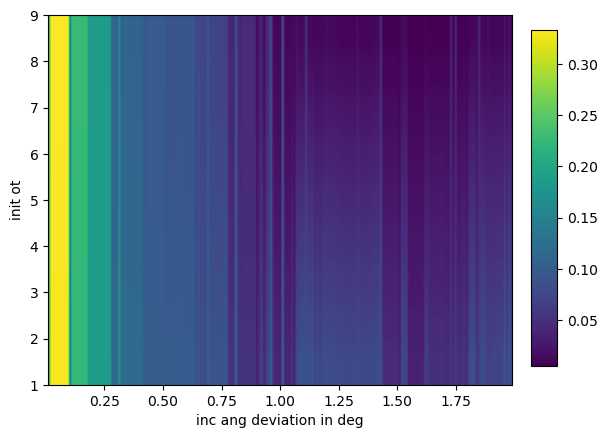

In [20]:
gen_angs_biases = list(range(1, 10))
gen_number = len(gen_angs_biases)
gen_loss_arr = np.empty((gen_number, len(designs)))

for i, gen_angs_bias in zip(range(gen_number), gen_angs_biases):
    gen_angs = [60. - gen_angs_bias, 60. + gen_angs_bias]

    def generalize(designs):
        gen_designs = []
        for design in designs:
            gen_design = copy.deepcopy(design)
            for inc_ang in gen_angs:
                gen_design.target_film.add_spec_param(inc_ang, WLS)
                gen_design.film.add_spec_param(inc_ang, WLS)
            gen_design.calculate_loss()
            gen_designs.append(gen_design)
        return gen_designs

    gen_designs = generalize(designs)

    for j in range(len(gen_designs)):
        gen_loss_arr[i, j] = gen_designs[j].loss

fig, ax = plt.subplots(1, 1)
target_ot = design.target_film.get_optical_thickness(wl)
im = ax.imshow(gen_loss_arr,
        aspect='auto',
        extent=(
            designs[0].init_ot / target_ot,
            designs[-1].init_ot / target_ot,
            gen_angs_biases[0],
            gen_angs_biases[-1]
        )
    )
ax.set_xlabel('inc ang deviation in deg')
ax.set_ylabel('init ot')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)